# Task:
Using the epicurious dataset, see if we can use the ingredient and keyword list to predict the rating. The dataset is a collection of recipes with key terms, their ingredients and ratings.
<br> [Link to Kaggle](https://www.kaggle.com/hugodarwood/epirecipes)

In [171]:
# Import modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import time

# Visuals.
%matplotlib inline
sns.set(style='white')

# Initial Data Exploration:

In [172]:
# Load dataset.
raw_data = pd.read_csv('~/src/data/unit3/epi_r.csv')
print(len(raw_data))
raw_data.head()

20052


,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [174]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

Note 25th percentile > mean. Likely there is some kind of outlier population. Some bad recipes may have very few very low reviews.

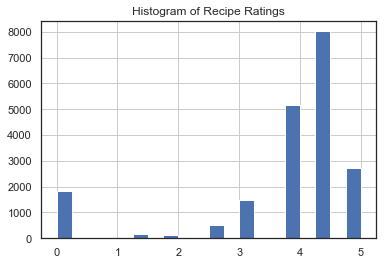

In [175]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [176]:
# Count nulls.
null_count = raw_data.isnull().sum()
null_count[null_count > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

# Base Case: Regression

In [177]:
#from sklearn.svm import SVR
#svr = SVR()
#X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], axis=1)
#Y = raw_data['rating']
#start_time = time.time()
#svr.fit(X,Y)
#print('Time taken: {} seconds'.format('%.1f' % (time.time() - start_time)))

In [178]:
#plt.scatter(Y, svr.predict(X))

In [179]:
#svr.score(X, Y)

SVR Score: 0.0385657

In [180]:
#from sklearn.model_selection import cross_val_score
#cross_val_score(SVR, X, Y, cv=5)

cross_val_scores: 0.01818511, 0.026411, 0.03037705, 0.01957949, 0.02451197

# Task:
Transform this regression problem into a binary classifier and clean up the feature set. Try to cut down to 30 of the most valuable features. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values. We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

# Treating the data

In [219]:
# Removing the nulls.
df1 = raw_data.dropna()
print('number of rows raw_data: ', len(raw_data))
print('number of rows df1: ', len(df1))
print('number of rows omitted due to null values: ', len(raw_data) - len(df1))

number of rows raw_data:  20052
number of rows df1:  15864
number of rows omitted due to null values:  4188


In [220]:
# Standardizing dietary features by removing the mean and scaling to unit variance.
scaled_diet_df = df1.copy()
scaler = StandardScaler()
diet_col_names = ['calories', 'protein', 'fat', 'sodium']
diet_features = scaled_diet_df[diet_col_names]
scaler = StandardScaler().fit(diet_features.values)
diet_features = scaler.transform(diet_features.values)
scaled_diet_df[diet_col_names] = diet_features
df2 = scaled_diet_df

In [221]:
# Creating binary feature. We're only keeping recipes with rating of 4 or greater.
df2['rating_cat'] = df2['rating'].apply(lambda x: 1 if x >= 4 else 0)
df2 = df2.drop(['rating'], axis=1)

In [207]:
# Assigning features to a correlation dataframe.
df_corre = df2.iloc[:, 1:]
df_corre = df_corre.drop(['rating_cat'], axis=1)

# Build correlation matrix.
corrmat = df_corre.corr()

# Total and sort by 30 most correlated/uncorrelated features.
corrmat['total'] = corrmat.sum(axis=1)
corre_top_30 = corrmat['total'].sort_values(ascending=False)[:31] #a series
corre_bot_30 = corrmat['total'].sort_values(ascending=True)[:31] #a series
print('Top 30 features with positive correlation:\n', corre_top_30)
print('\n')
print('Bottom 30 features with negative correlation:\n', corre_bot_30)

Top 30 features with positive correlation:
 peanut free          10.101472
soy free              9.915668
tree nut free         8.476456
pescatarian           8.209225
kosher                8.205207
wheat/gluten-free     7.867733
dairy free            7.536439
dinner                5.985443
no sugar added        5.854478
party                 5.428724
vegetarian            5.338622
lunch                 4.828214
healthy               4.522962
shower                4.483551
vegan                 4.406196
drink                 4.267215
paleo                 4.169839
alcoholic             4.096416
sugar conscious       4.063960
high fiber            3.977727
calories              3.842199
sodium                3.832546
fourth of july        3.805920
brunch                3.790363
fat                   3.786624
potluck               3.730459
engagement party      3.671014
picnic                3.645612
protein               3.632713
kidney friendly       3.572532
fat free              3.54

# Model

In [208]:
# Final Dataframe.
model_df = df2.drop(['title'], axis=1)
#model_df.head()

In [223]:
#top_corre = corre_top_30
#bot_corre = corre_bot_30
#nutrition = model_df.iloc[:, :4]
#keywords = model_df.loc[:, '#cakeweek':'turkey']

# Assigning the model inputs.
target = model_df['rating_cat']
pos_vars = ['peanut free', 'soy free', 'tree nut free', 'pescatarian', 'kosher',
              'wheat/gluten-free', 'dairy free', 'dinner', 'no sugar added', 'party',
              'vegetarian', 'lunch', 'healthy', 'shower', 'vegan', 'drink', 'paleo',
              'alcoholic', 'sugar conscious', 'high fiber', 'calories', 'sodium',
              'fourth of july', 'brunch', 'fat', 'potluck', 'engagement party',
              'picnic', 'protein', 'kidney friendly', 'fat free']
neg_vars = ['gourmet', 'sauce', 'condiment/spread', 'quick & easy', 'herb', 'bread',
            'pasta', 'turkey', 'chicken', 'garlic', 'salad dressing', 'dairy', 'onion',
            'sauté', 'pepper', 'poultry', 'beef', 'bake', 'cornmeal', 'mustard',
            'soup/stew', 'tomato', 'fish', 'veal', 'mushroom', 'rosemary', 'parmesan',
            'olive', 'potato', 'rice', 'no-cook']
final_vars = pos_vars
vars_X = model_df[final_vars]
#features = model_df.drop(['rating_cat'], axis=1)
feature_cols = vars_X.columns

In [224]:
# 75/25 train/test split  
train, test = train_test_split(model_df, test_size=0.25, random_state=42)
X_test = test[feature_cols]
Y_test = test['rating_cat']
X_train = train[feature_cols]
Y_train = train['rating_cat']

In [225]:
start_time = time.time()

# Declare the model.
svc = SVC()

# Fit the model.
svc.fit(X_train, Y_train)

# Display.
print('Time taken: {} seconds'.format('%.1f' % (time.time() - start_time)))
print('\nTraining Set Accuracy:')
print(svc.score(X_train, Y_train))
print('\nTest Set Accuracy:')
print(svc.score(X_test, Y_test))

Time taken: 7.5 seconds

Training Set Accuracy:
0.5662296184232645

Test Set Accuracy:
0.5620272314674736


Not bad, more can be done. Consider wip.